In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
import numpy as np

torch.manual_seed(0)
!pip install keras tensorflow

from keras.datasets import mnist

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = torch.tensor(X_train, dtype=torch.float32).cuda() / 255
X_test = torch.tensor(X_test, dtype=torch.float32).cuda() / 255

# X_train = (X_train - X_train.mean()) / X_train.std()
# X_test = (X_test - X_train.mean()) / X_train.std()

y_train = torch.tensor(y_train, dtype=torch.long).cuda()
y_test = torch.tensor(y_test, dtype=torch.long).cuda()

X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [3]:
class PositionEmbedding(nn.Module):

    def __init__(self,
                 num_embeddings,
                 embedding_dim):
        super(PositionEmbedding, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        
        self.weight = nn.Parameter(torch.Tensor(num_embeddings, embedding_dim))
        torch.nn.init.xavier_normal_(self.weight)

    def forward(self, x):
        batch_size, seq_len = x.size()[:2]
        embeddings = self.weight[:seq_len, :].view(1, seq_len, self.embedding_dim)
        return x + embeddings

class Model(torch.nn.Module):
    def __init__(self, patch_size=4, k_dim=16, v_dim=16, model_dim=16, image_size=(28,28)):
        super().__init__()
        
        self.patch_size = patch_size
        self.n_tokens = (image_size[0] // self.patch_size)**2
        
        self.softmax = torch.nn.Softmax(dim=-1)
        self.relu = torch.nn.ReLU()
        
        self.encode = torch.nn.Linear(self.patch_size**2, model_dim, bias=False)
        
        self.W_q = torch.nn.Linear(model_dim, k_dim, bias=False)
        self.W_k = torch.nn.Linear(model_dim, k_dim, bias=False)
        self.W_v = torch.nn.Linear(model_dim, v_dim, bias=False)
        
        self.layer_norm = torch.nn.LayerNorm(v_dim, eps=1e-6)
#         self.W_1 = torch.nn.Linear(v_dim, 12)
        self.W_0 = torch.nn.Linear(v_dim, 10)
       
        self.W_2 = torch.nn.Linear(49*16, v_dim)
        
        self.dropout = nn.Dropout(0.1)

        self.embed = PositionEmbedding(self.n_tokens+1, model_dim)
        
        self.sqrt_k = torch.sqrt(torch.tensor(k_dim, dtype=torch.float))
        self.cls = torch.nn.Parameter(torch.zeros(1, 1, self.patch_size**2), requires_grad=False)
        
    def forward(self, x):
        
        x = x.reshape(x.shape[0], self.n_tokens, self.patch_size**2)
        
        x = torch.cat((self.cls.clone().repeat(x.shape[0],1,1), x), dim=1)
        x = self.encode(x)
        x = self.embed(x)

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        self.weights = self.softmax( torch.einsum('bij,bkj->bik', Q, K) ) / self.sqrt_k

        self.attention = torch.matmul(self.weights, V)
        
        out = torch.flatten(self.attention[:,0].unsqueeze(1), 1)
        out = self.W_0(out)
                
        pred = self.softmax(out)
        
        return pred
    
    def accuracy(self, pred, target):
        return torch.sum(torch.argmax(pred,dim=1) == target) / pred.shape[0]
    

In [4]:
patch_size = 4
img_size = 28
model = Model(patch_size=patch_size, k_dim=32, v_dim=32, model_dim=16, image_size=(img_size, img_size))
model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
batch_size = 256
n_batches = X_train.shape[0] // batch_size

epochs = 5000
pbar = tqdm.tqdm(range(epochs))

log = {'loss': [], 'train_acc': [], 'test_acc': []}

for e in pbar:
    
    idcs = torch.randperm(X_train.shape[0])
    X_train_shuffle = X_train[idcs]
    y_train_suffle = y_train[idcs]
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_test_acc = []
    
    for b in range(n_batches):
        
        X_train_batch = X_train_shuffle[b*batch_size:(b+1)*batch_size]
        y_train_batch = y_train_suffle[b*batch_size:(b+1)*batch_size]
        
        y_train_pred = model(X_train_batch)
        
        loss = criterion(y_train_pred, y_train_batch)
        
        epoch_loss += [float(loss)]
        epoch_train_acc += [float(model.accuracy(y_train_pred, y_train_batch))]

        optim.zero_grad()
        loss.backward()
        optim.step()
        
    with torch.no_grad():
        y_test_pred = model(X_test)
        epoch_test_acc += [float(model.accuracy(y_test_pred, y_test))]
    
    log['loss'] += [np.sum(epoch_loss) / n_batches]
    log['train_acc'] += [np.sum(epoch_train_acc) / n_batches]
    log['test_acc'] += [np.sum(epoch_test_acc)]

    pbar.set_description(f'loss:{np.round(log["loss"][-1],4)} \
                            train_acc:{np.round(log["train_acc"][-1],4)} \
                            test_acc:{np.round(log["test_acc"][-1],4)} \
                            ')

loss:1.5484                             train_acc:0.9132                             test_acc:0.9084                             : 100%|██████████████████████████| 5000/5000 [50:04<00:00,  1.66it/s]


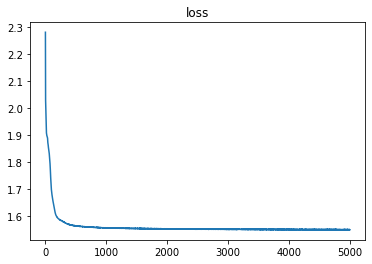

In [10]:
import matplotlib.pyplot as plt
plt.plot(log['loss'])
plt.title('loss')
plt.show()

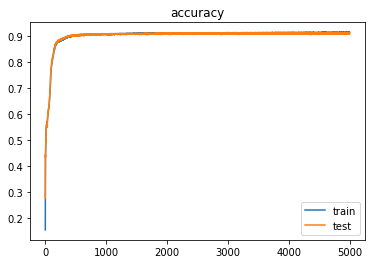

In [11]:
plt.plot(log['train_acc'], label='train')
plt.plot(log['test_acc'], label='test')
plt.title('accuracy')
plt.legend()
plt.show()

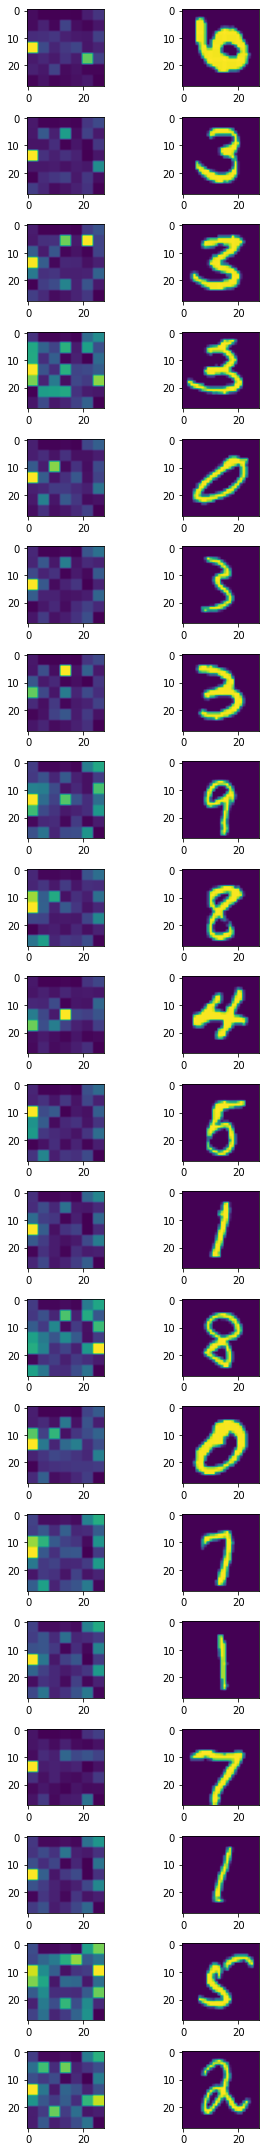

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

token_size = img_size//patch_size

with torch.no_grad():
    model(X_train_batch)
    cls_token = 0
    weights = model.weights[:,cls_token,:-1].reshape(-1,token_size,token_size)
    
#     weights = torch.sum(model.attention[:,:-1],dim=-1).reshape(-1,7,7)

    weights = torch.nn.functional.interpolate(weights.unsqueeze(1), size=(img_size,img_size)).squeeze(1)

sample_size = 20

fig, ax = plt.subplots(sample_size,2,figsize=(5,30))
for i in range(sample_size):
    w = ax[i][0].imshow(weights[i].cpu().detach().numpy())
    rgb = ax[i][1].imshow(X_train_batch[i].cpu().detach().numpy().reshape(img_size,img_size))

fig.tight_layout()
plt.show()

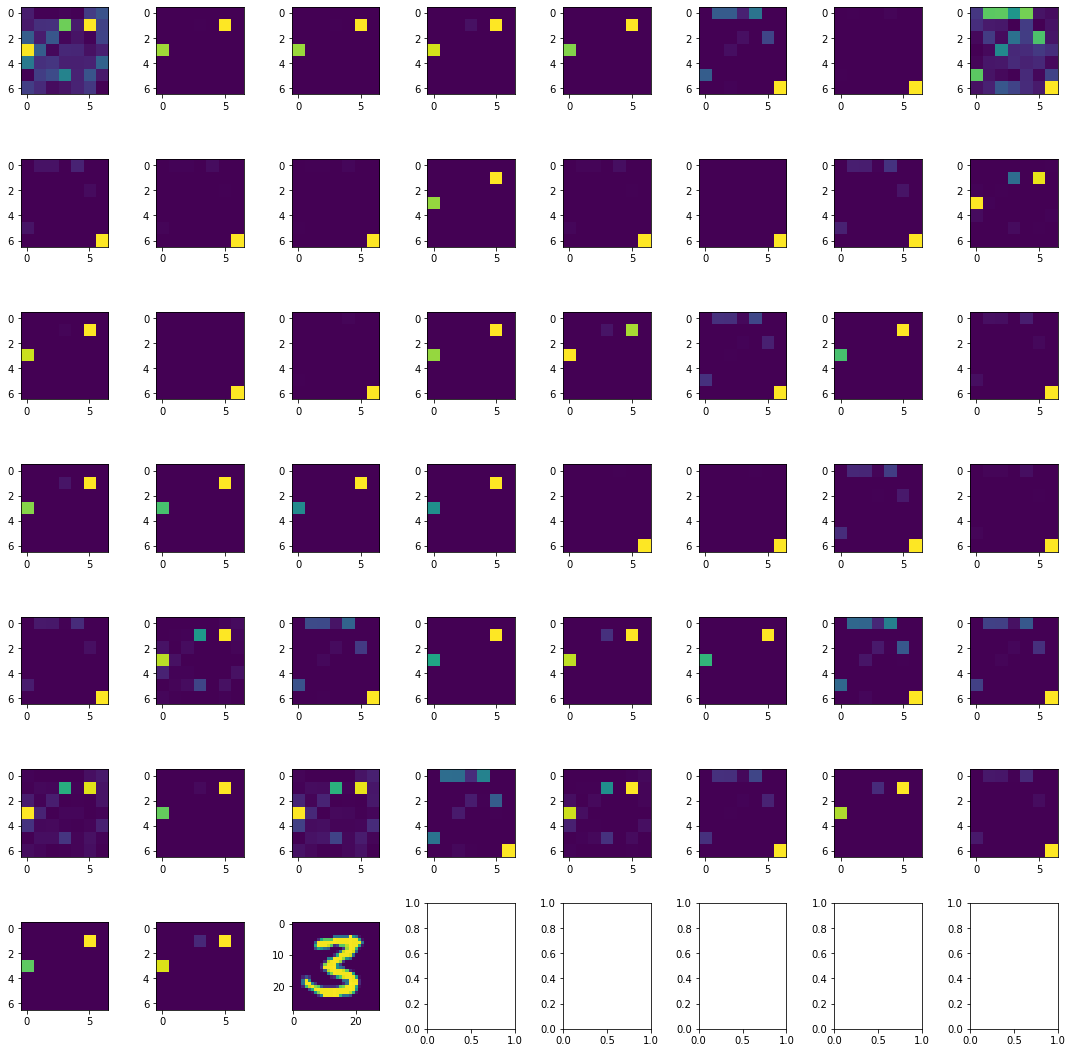

In [13]:
example_idx = 2

with torch.no_grad():
    model(X_train_batch)
    weights = model.weights[:,:,:-1].reshape(-1,model.weights.shape[1],token_size,token_size)

fig, ax = plt.subplots(7,8,figsize=(15,15))

ctr=0
for i in range(7):
    for j in range(8):
        if ctr >= weights.shape[1]:
            rgb = ax[i][j].imshow(X_train_batch[example_idx].cpu().detach().numpy().reshape(img_size,img_size))
            break
        else:
            w = ax[i][j].imshow(weights[example_idx,ctr].cpu().detach().numpy())
            ctr += 1
        
        
fig.tight_layout()
plt.show()

### 